### Tópicos Especiais em Inteligência Artificial: Redes Neurais Artificiais
### Professor Ciniro Nametala - IFMG

## Geração de imagens falsas com Deep Convolutional Generative Adversarial Networks (DCGAN)

Neste trabalho vamos utilizar o *dataset Fashion-MNIST* disponível no [repositório oficial do Zalando Research](https://github.com/zalandoresearch/fashion-mnist). Este é um conjunto de dados composto por 70.000 imagens em escala de cinza com resolução 28×28 pixels, divididas em 10 classes de roupas e acessórios. O objetivo é treinar uma GAN (Generative Adversarial Network) capaz de **gerar imagens novas de roupas** que não existem no dataset original.

**Classes do dataset:**
| Label | Classe |
|-------|--------|
| 0 | Camiseta |
| 1 | Calça |
| 2 | Suéter |
| 3 | Vestido |
| 4 | Casaco |
| 5 | Sandália |
| 6 | Camisa |
| 7 | Tênis |
| 8 | Bolsa |
| 9 | Bota |

**Arquitetura GAN:**

Uma GAN é composta por duas redes neurais que competem entre si:
- **Gerador (G):** Recebe um vetor de ruído aleatório e gera imagens falsas
- **Discriminador (D):** Recebe imagens (reais ou falsas) e classifica como real ou falsa

O treinamento é um jogo de soma zero: o Gerador tenta enganar o Discriminador, enquanto o Discriminador tenta não ser enganado. Ao final, o Gerador aprende a criar imagens realistas.

## 1. Preparação do ambiente

### 1.1 Configurações de ambiente

In [26]:
#funcao para deixar o jupyter com celulas preenchendo toda a tela
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

### 1.2 Importação de pacotes

In [27]:
#importacao de bibliotecas

#para exportar o requirements
import subprocess
import sys
import os

#bibliotecas para trabalhar com dados e graficos
import numpy as np
import matplotlib.pyplot as plt

#biblioteca para gerar gif
import imageio

#biblioteca para tocar sons
import pygame

#bibliotecas para deep learning
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU, BatchNormalization, Dropout
#se estiver usando windows ou linux comente a linha a seguir e descomente a próxima
from tensorflow.keras.optimizers import Adam
#from tensorflow.keras.optimizers import Adam

from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import plot_model

#biblioteca para barra de progresso
from tqdm import tqdm

### 1.3 Verificando versões

In [28]:
import tensorflow as tf
import keras
print('tensorflow:', tf.__version__)
print('keras:', keras.__version__)

tensorflow: 2.20.0
keras: 3.12.0


### 1.4 Checagem de GPU

In [29]:
#checagem de GPU
print('tensorflow:', tf.__version__)
print('gpu disponivel:', len(tf.config.list_physical_devices('GPU')) > 0)
print('gpu:', tf.config.list_physical_devices('GPU'))

tensorflow: 2.20.0
gpu disponivel: False
gpu: []


In [30]:
#exportacao do requirements.txt
def exportarRequirements():
    try:
        result = subprocess.run([sys.executable, '-m', 'pip', 'freeze'], 
                                capture_output=True, 
                                text=True, 
                                check=True)

        with open('requirements.txt', 'w') as f:
            f.write(result.stdout)

        print('requirements.txt exportado com sucesso')
    except subprocess.CalledProcessError as e:
        print(f'erro ao exportar requirements: {e}')

exportarRequirements()

requirements.txt exportado com sucesso


## 2. Configurações do experimento

In [31]:
#------------------------------
#CONFIGURACOES DE VISUALIZACAO
#------------------------------

#exibir grade de imagens geradas ao final do treino
show_generated_grid = True

#salvar imagens durante o treino (a cada n epocas)
save_evolution_images = True

#gerar gif animado da evolucao do treinamento
generate_evolution_gif = True

#exibir interpolacao no espaco latente
show_latent_interpolation = True

#------------------------------
#CONFIGURACOES DE TREINAMENTO
#------------------------------

#treinar um novo modelo ou carregar existente
new_model = False

#numero de epocas de treinamento
epochs = 100

#tamanho do batch
batch_size = 128

#dimensao do espaco latente (vetor de ruido)
latent_dim = 100

#intervalo para salvar imagens durante treino
save_interval = 10

#learning rate
learning_rate = 0.0002

#beta1 para adam
beta1 = 0.5

#------------------------------
#CONFIGURACOES DE ARQUIVOS
#------------------------------

#nome do modelo
model_name = 'dcgan_fashion_mnist'

#pasta para salvar imagens da evolucao
evolution_folder = 'evolution_images'

#pasta para salvar modelos
models_folder = 'models'

#criar pastas se nao existirem
os.makedirs(evolution_folder, exist_ok=True)
os.makedirs(models_folder, exist_ok=True)

## 3. Importação de dados

In [32]:
#carregando o dataset fashion mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

#nomes das classes
class_names = ['Camiseta', 'Calca', 'Sueter', 'Vestido', 'Casaco',
                'Sandalia', 'Camisa', 'Tenis', 'Bolsa', 'Bota']

print(f'x_train shape: {x_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'x_test shape: {x_test.shape}')
print(f'y_test shape: {y_test.shape}')

x_train shape: (60000, 28, 28)
y_train shape: (60000,)
x_test shape: (10000, 28, 28)
y_test shape: (10000,)


## 4. Análise de dados

### 4.1 Visualização das amostras

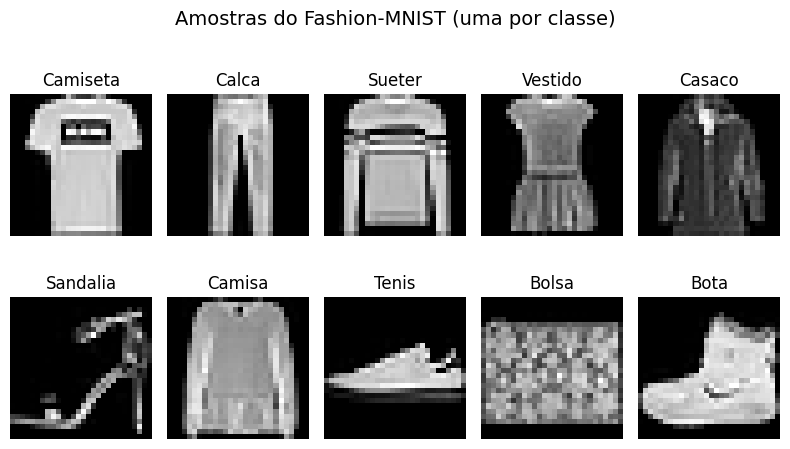

In [33]:
#visualizando algumas amostras do dataset
fig, axes = plt.subplots(2, 5, figsize=(8, 5))
axes = axes.flatten()

for i in range(10):
    #encontrar primeira imagem de cada classe
    idx = np.where(y_train == i)[0][0]
    axes[i].imshow(x_train[idx], cmap='gray')
    axes[i].set_title(class_names[i])
    axes[i].axis('off')

plt.suptitle('Amostras do Fashion-MNIST (uma por classe)', fontsize=14)
plt.tight_layout()
plt.show()

### 4.2 Sumarização estatística

In [34]:
#estatisticas do dataset
print('='*50)
print('ESTATISTICAS DO DATASET')
print('='*50)
print(f'total de amostras de treino: {len(x_train)}')
print(f'total de amostras de teste: {len(x_test)}')
print(f'dimensoes da imagem: {x_train.shape[1]}x{x_train.shape[2]}')
print(f'valor minimo dos pixels: {x_train.min()}')
print(f'valor maximo dos pixels: {x_train.max()}')
print(f'tipo de dado: {x_train.dtype}')
print('='*50)

#distribuicao das classes
print('\nDISTRIBUICAO DAS CLASSES (treino):')
for i in range(10):
    count = np.sum(y_train == i)
    print(f'{class_names[i]}: {count} ({100*count/len(y_train):.1f}%)')

ESTATISTICAS DO DATASET
total de amostras de treino: 60000
total de amostras de teste: 10000
dimensoes da imagem: 28x28
valor minimo dos pixels: 0
valor maximo dos pixels: 255
tipo de dado: uint8

DISTRIBUICAO DAS CLASSES (treino):
Camiseta: 6000 (10.0%)
Calca: 6000 (10.0%)
Sueter: 6000 (10.0%)
Vestido: 6000 (10.0%)
Casaco: 6000 (10.0%)
Sandalia: 6000 (10.0%)
Camisa: 6000 (10.0%)
Tenis: 6000 (10.0%)
Bolsa: 6000 (10.0%)
Bota: 6000 (10.0%)


### 4.3 Pré-processamento dos dados

In [35]:
#pre-processamento: normalizar para [-1, 1] (padrao para GANs com tanh)
x_train = x_train.astype('float32')
x_train = (x_train - 127.5) / 127.5

#adicionar dimensao do canal (28, 28) -> (28, 28, 1)
x_train = np.expand_dims(x_train, axis=-1)

print(f'shape apos pre-processamento: {x_train.shape}')
print(f'valor minimo: {x_train.min()}')
print(f'valor maximo: {x_train.max()}')

shape apos pre-processamento: (60000, 28, 28, 1)
valor minimo: -1.0
valor maximo: 1.0


## 5. Treinamento do modelo

### 5.1 Construção do Gerador

In [36]:
#funcao para construir o gerador
def construirGerador(latent_dim):
    #entrada: vetor de ruido
    noise_input = Input(shape=(latent_dim,), name='noise_input')
    
    #camada densa inicial: projeta para 7x7x256
    x = Dense(7 * 7 * 256, use_bias=False)(noise_input)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Reshape((7, 7, 256))(x)
    
    #conv transposta 1: 7x7x256 -> 7x7x128
    x = Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    #conv transposta 2: 7x7x128 -> 14x14x64
    x = Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    #conv transposta 3: 14x14x64 -> 28x28x1
    output = Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')(x)
    
    model = Model(noise_input, output, name='gerador')
    return model

#construir gerador
gerador = construirGerador(latent_dim)
print('gerador construido com sucesso')

gerador construido com sucesso


### 5.2 Construção do Discriminador

In [37]:
#funcao para construir o discriminador
def construirDiscriminador(img_shape):
    #entrada: imagem
    img_input = Input(shape=img_shape, name='img_input')
    
    #conv 1: 28x28x1 -> 14x14x64
    x = Conv2D(64, (5, 5), strides=(2, 2), padding='same')(img_input)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.3)(x)
    
    #conv 2: 14x14x64 -> 7x7x128
    x = Conv2D(128, (5, 5), strides=(2, 2), padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.3)(x)
    
    #flatten e saida
    x = Flatten()(x)
    output = Dense(1, activation='sigmoid')(x)
    
    model = Model(img_input, output, name='discriminador')
    return model

#construir discriminador
img_shape = (28, 28, 1)
discriminador = construirDiscriminador(img_shape)
print('discriminador construido com sucesso')

discriminador construido com sucesso


### 5.3 Construção da GAN

In [38]:
#compilar discriminador
opt_disc = Adam(learning_rate=learning_rate, beta_1=beta1)
discriminador.compile(loss='binary_crossentropy', optimizer=opt_disc, metrics=['accuracy'])

#para treinar o gerador, congelamos o discriminador
discriminador.trainable = False

#construir modelo combinado (gan)
noise_input = Input(shape=(latent_dim,))
img_gerada = gerador(noise_input)
validade = discriminador(img_gerada)

gan = Model(noise_input, validade, name='gan')

#compilar gan
opt_gan = Adam(learning_rate=learning_rate, beta_1=beta1)
gan.compile(loss='binary_crossentropy', optimizer=opt_gan)

print('gan construida com sucesso')

gan construida com sucesso


### 5.4 Inspecionando os modelos

In [39]:
#sumario do gerador
print('='*60)
print('GERADOR')
print('='*60)
gerador.summary()

GERADOR


Model: "gerador"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ noise_input (InputLayer)        │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 12544)          │     1,254,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 12544)          │        50,176 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 7, 7, 128)      │       819,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 14, 14, 64)     │       204,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 28, 28, 1)      │         1,600 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,330,944 (8.89 MB)

 Trainable params: 2,305,472 (8.79 MB)

 Non-trainable params: 25,472 (99.50 KB)

In [40]:
#sumario do discriminador
print('='*60)
print('DISCRIMINADOR')
print('='*60)
discriminador.summary()

DISCRIMINADOR


Model: "discriminador"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ img_input (InputLayer)          │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 14, 14, 64)     │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 7, 7, 128)      │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_9 (LeakyReLU)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │         6,273 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 212,865 (831.50 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 212,865 (831.50 KB)

In [41]:
#sumario da gan
print('='*60)
print('GAN (MODELO COMBINADO)')
print('='*60)
gan.summary()

GAN (MODELO COMBINADO)


Model: "gan"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gerador (Functional)            │ (None, 28, 28, 1)      │     2,330,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ discriminador (Functional)      │ (None, 1)              │       212,865 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,543,809 (9.70 MB)

 Trainable params: 2,305,472 (8.79 MB)

 Non-trainable params: 238,337 (931.00 KB)

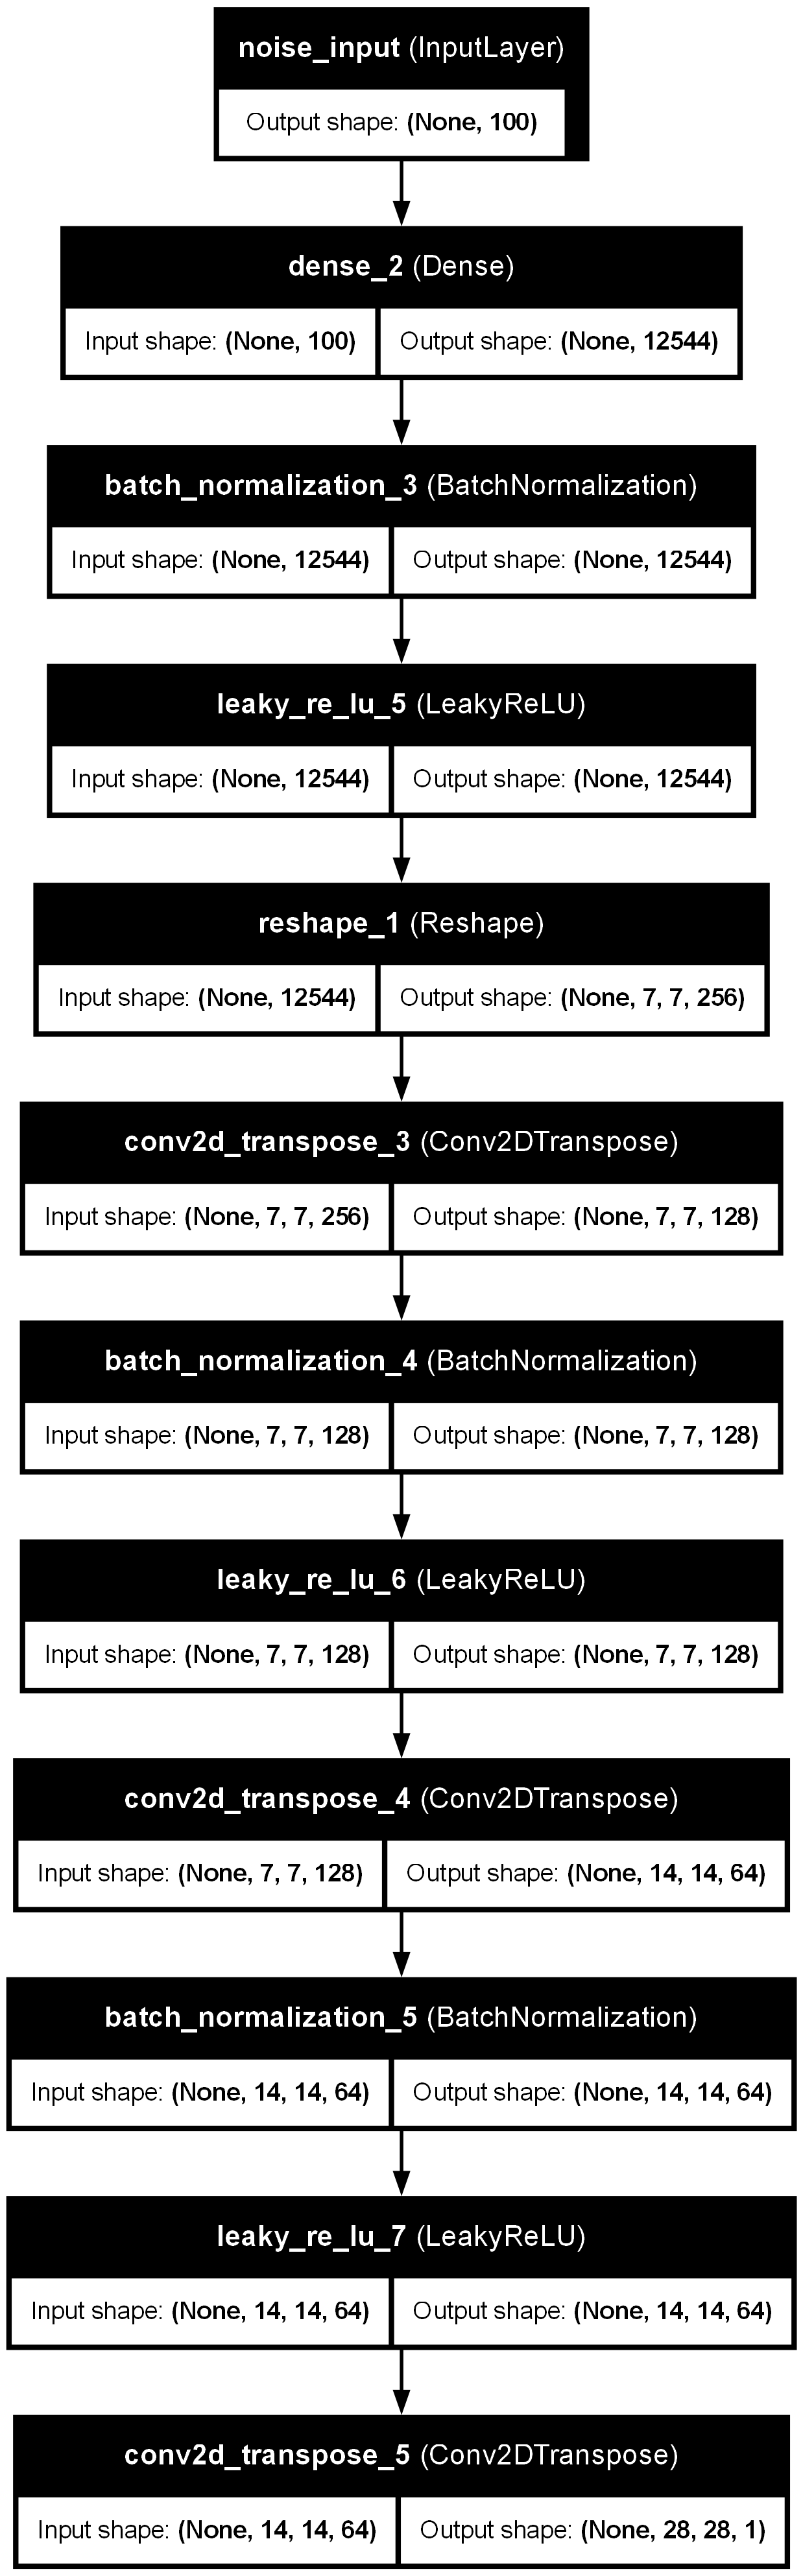

In [42]:
#plot do gerador
plot_model(gerador, to_file='gerador_plot.png', show_shapes=True, show_layer_names=True)

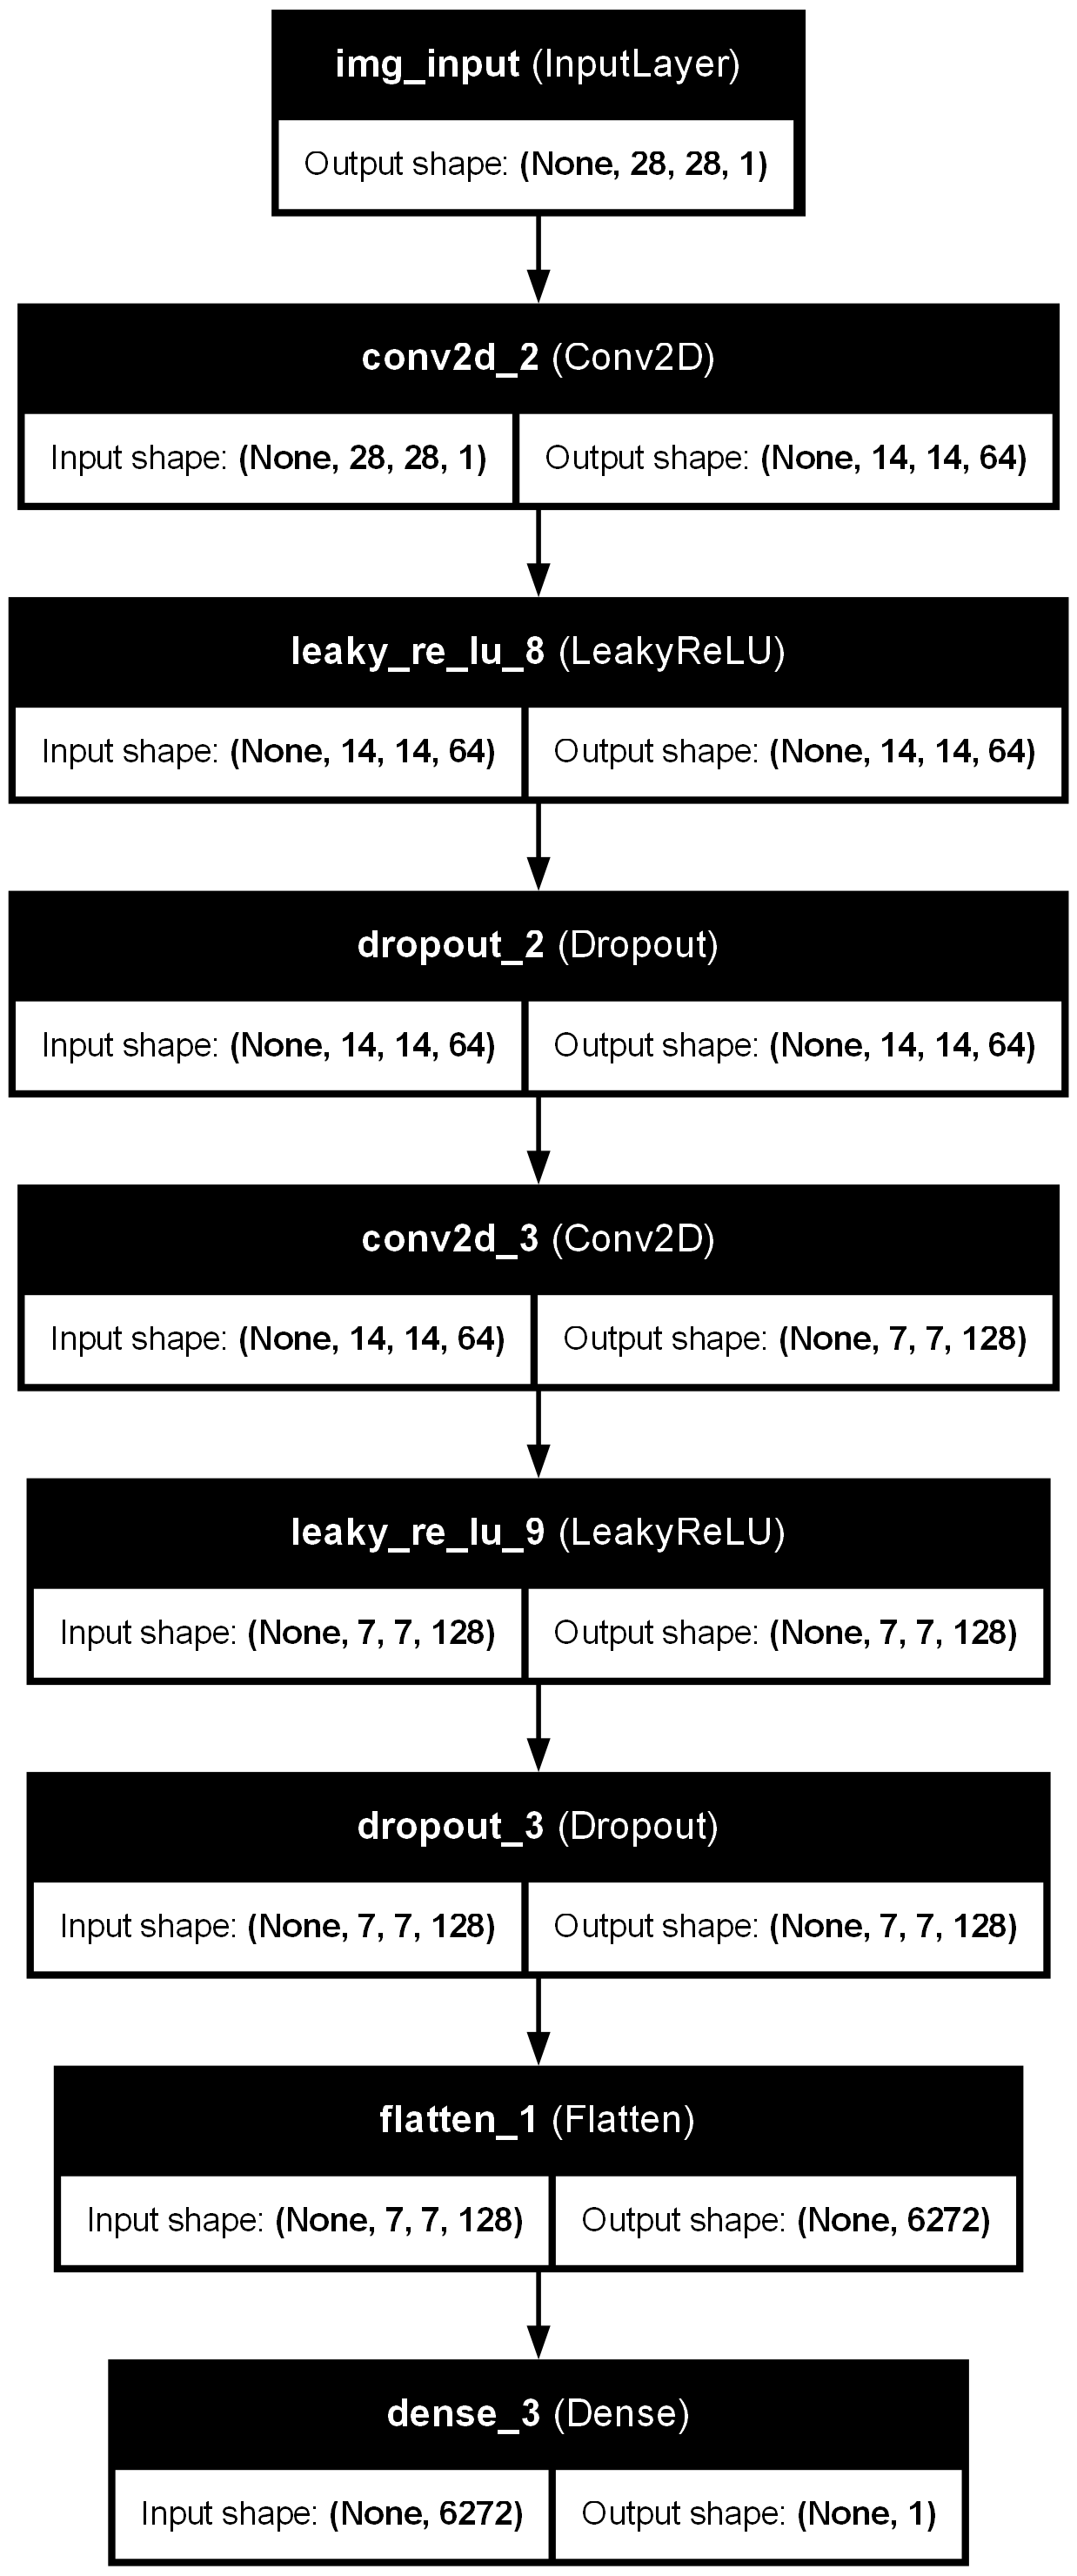

In [43]:
#plot do discriminador
plot_model(discriminador, to_file='discriminador_plot.png', show_shapes=True, show_layer_names=True)

### 5.5 Funções auxiliares de treinamento

In [44]:
#funcao para salvar grade de imagens geradas
def salvarGradeImagens(epoch, gerador, latent_dim, examples=16, dim=(4, 4), figsize=(6, 6)):
    noise = np.random.normal(0, 1, (examples, latent_dim))
    gen_imgs = gerador.predict(noise, verbose=0)
    
    #desnormalizar de [-1, 1] para [0, 1]
    gen_imgs = 0.5 * gen_imgs + 0.5
    
    fig, axes = plt.subplots(dim[0], dim[1], figsize=figsize)
    cnt = 0
    for i in range(dim[0]):
        for j in range(dim[1]):
            axes[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axes[i, j].axis('off')
            cnt += 1
    
    plt.suptitle(f'Epoca {epoch}', fontsize=14)
    plt.tight_layout()
    
    if save_evolution_images:
        plt.savefig(f'{evolution_folder}/epoca_{epoch:04d}.png')
    
    plt.close()

In [45]:
#funcao para gerar ruido latente
def gerarRuido(batch_size, latent_dim):
    return np.random.normal(0, 1, (batch_size, latent_dim))

### 5.6 Otimização do modelo

In [46]:
if new_model:
    #listas para armazenar historico de losses
    d_losses = []
    g_losses = []
    d_accs = []
    
    #labels para treino
    real_labels = np.ones((batch_size, 1))
    fake_labels = np.zeros((batch_size, 1))
    
    #numero de batches por epoca
    n_batches = x_train.shape[0] // batch_size
    
    print('='*60)
    print('INICIANDO TREINAMENTO')
    print('='*60)
    print(f'epocas: {epochs}')
    print(f'batch size: {batch_size}')
    print(f'batches por epoca: {n_batches}')
    print(f'latent dim: {latent_dim}')
    print('='*60)
    
    #salvar imagem inicial (epoca 0)
    salvarGradeImagens(0, gerador, latent_dim)
    
    #loop de treinamento
    for epoch in tqdm(range(1, epochs + 1), desc='Treinando'):
        epoch_d_loss = 0
        epoch_g_loss = 0
        epoch_d_acc = 0
        
        for batch in range(n_batches):
            #---------------------
            #treinar discriminador
            #---------------------
            
            #selecionar batch de imagens reais
            idx = np.random.randint(0, x_train.shape[0], batch_size)
            real_imgs = x_train[idx]
            
            #gerar imagens falsas
            noise = gerarRuido(batch_size, latent_dim)
            fake_imgs = gerador.predict(noise, verbose=0)
            
            #treinar discriminador em imagens reais e falsas
            d_loss_real = discriminador.train_on_batch(real_imgs, real_labels)
            d_loss_fake = discriminador.train_on_batch(fake_imgs, fake_labels)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            
            #---------------------
            #treinar gerador
            #---------------------
            
            #gerar novo ruido
            noise = gerarRuido(batch_size, latent_dim)
            
            #treinar gerador (queremos que discriminador classifique como real)
            g_loss = gan.train_on_batch(noise, real_labels)
            
            epoch_d_loss += d_loss[0]
            epoch_g_loss += g_loss
            epoch_d_acc += d_loss[1]
        
        #media das losses da epoca
        epoch_d_loss /= n_batches
        epoch_g_loss /= n_batches
        epoch_d_acc /= n_batches
        
        d_losses.append(epoch_d_loss)
        g_losses.append(epoch_g_loss)
        d_accs.append(epoch_d_acc)
        
        #salvar imagens a cada save_interval epocas
        if epoch % save_interval == 0:
            salvarGradeImagens(epoch, gerador, latent_dim)
            print(f'epoca {epoch}/{epochs} - d_loss: {epoch_d_loss:.4f} - g_loss: {epoch_g_loss:.4f} - d_acc: {epoch_d_acc:.4f}')
    
    #salvar modelos
    gerador.save(f'{models_folder}/{model_name}_gerador.h5')
    discriminador.save(f'{models_folder}/{model_name}_discriminador.h5')
    
    #salvar historico
    history = {'d_loss': d_losses, 'g_loss': g_losses, 'd_acc': d_accs}
    np.save(f'{models_folder}/{model_name}_history.npy', history)
    
    print('\nmodelos salvos com sucesso')

else:
    #carregar modelos existentes
    gerador = load_model(f'{models_folder}/{model_name}_gerador.h5')
    discriminador = load_model(f'{models_folder}/{model_name}_discriminador.h5')
    history = np.load(f'{models_folder}/{model_name}_history.npy', allow_pickle=True).item()
    d_losses = history['d_loss']
    g_losses = history['g_loss']
    d_accs = history['d_acc']
    print('modelos carregados com sucesso')

TypeError: Error when deserializing class 'Conv2DTranspose' using config={'name': 'conv2d_transpose', 'trainable': True, 'dtype': 'float32', 'filters': 128, 'kernel_size': [5, 5], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None, 'output_padding': None}.

Exception encountered: Unrecognized keyword arguments passed to Conv2DTranspose: {'groups': 1}

### 5.7 Avaliação da evolução do treinamento

NameError: name 'd_losses' is not defined

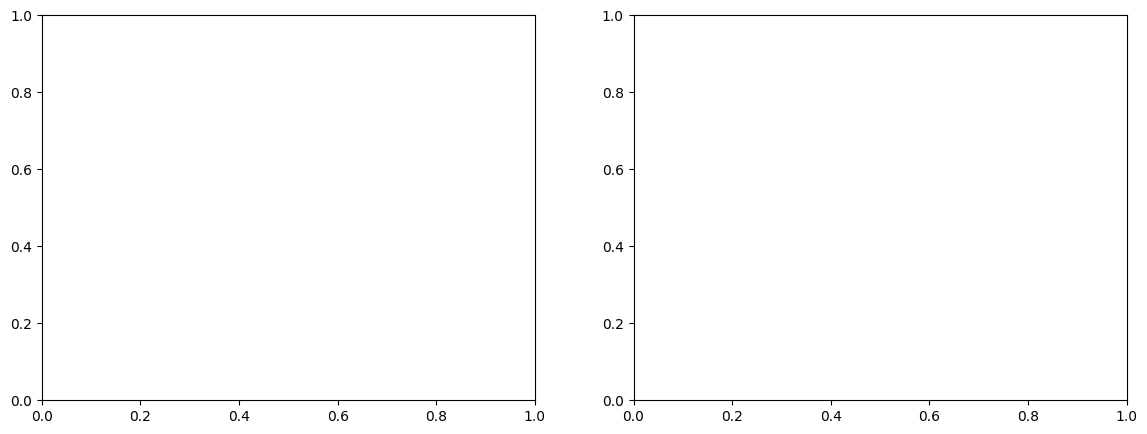

In [ ]:
#plot das curvas de loss
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

#grafico de losses
ax1.plot(d_losses, label='discriminador', alpha=0.8)
ax1.plot(g_losses, label='gerador', alpha=0.8)
ax1.set_xlabel('Epoca')
ax1.set_ylabel('Loss')
ax1.set_title('Evolucao das Losses')
ax1.legend()
ax1.grid(True, alpha=0.3)

#grafico de acuracia do discriminador
ax2.plot(d_accs, label='discriminador', color='green', alpha=0.8)
ax2.axhline(y=0.5, color='r', linestyle='--', label='equilibrio (0.5)')
ax2.set_xlabel('Epoca')
ax2.set_ylabel('Acuracia')
ax2.set_title('Acuracia do Discriminador')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Testando as gerações

### 6.1 Gerando imagens com o modelo treinado

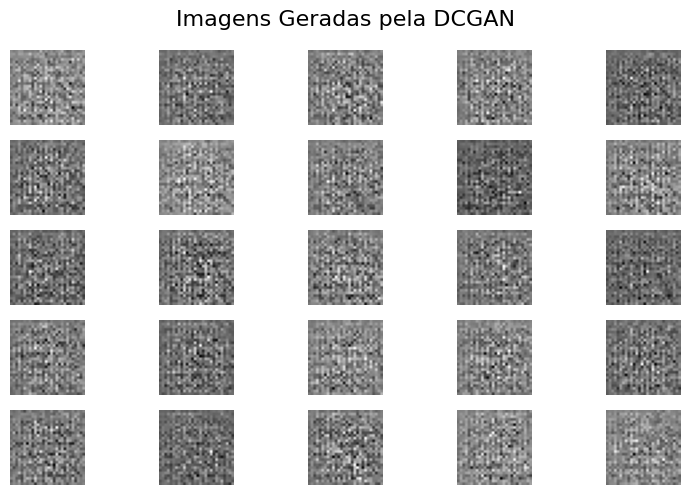

In [47]:
if show_generated_grid:
    #gerar grade maior de imagens
    n_examples = 25
    noise = gerarRuido(n_examples, latent_dim)
    gen_imgs = gerador.predict(noise, verbose=0)
    
    #desnormalizar
    gen_imgs = 0.5 * gen_imgs + 0.5
    
    #plot
    fig, axes = plt.subplots(5, 5, figsize=(8, 5))
    cnt = 0
    for i in range(5):
        for j in range(5):
            axes[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axes[i, j].axis('off')
            cnt += 1
    
    plt.suptitle('Imagens Geradas pela DCGAN', fontsize=16)
    plt.tight_layout()
    plt.show()

### 6.2 Interpolação no espaço latente

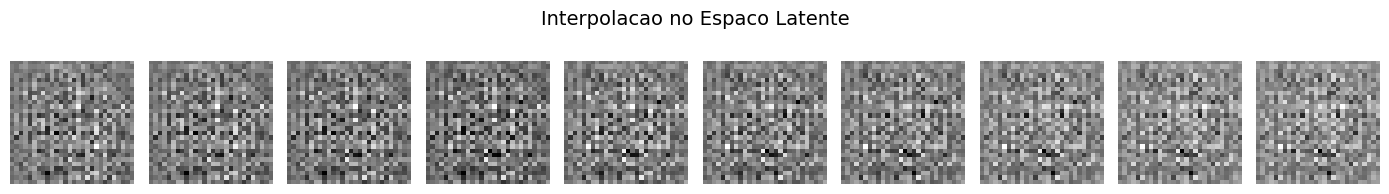

In [48]:
if show_latent_interpolation:
    #funcao para interpolar entre dois pontos no espaco latente
    def interpolarEspacoLatente(gerador, latent_dim, n_steps=10):
        #gerar dois pontos aleatorios
        z1 = np.random.normal(0, 1, (1, latent_dim))
        z2 = np.random.normal(0, 1, (1, latent_dim))
        
        #interpolar
        ratios = np.linspace(0, 1, n_steps)
        vectors = [(1 - ratio) * z1 + ratio * z2 for ratio in ratios]
        vectors = np.vstack(vectors)
        
        #gerar imagens
        gen_imgs = gerador.predict(vectors, verbose=0)
        gen_imgs = 0.5 * gen_imgs + 0.5
        
        return gen_imgs
    
    #gerar interpolacao
    n_steps = 10
    interp_imgs = interpolarEspacoLatente(gerador, latent_dim, n_steps)
    
    #plot
    fig, axes = plt.subplots(1, n_steps, figsize=(14, 2))
    for i in range(n_steps):
        axes[i].imshow(interp_imgs[i, :, :, 0], cmap='gray')
        axes[i].axis('off')
    
    plt.suptitle('Interpolacao no Espaco Latente', fontsize=14)
    plt.tight_layout()
    plt.show()

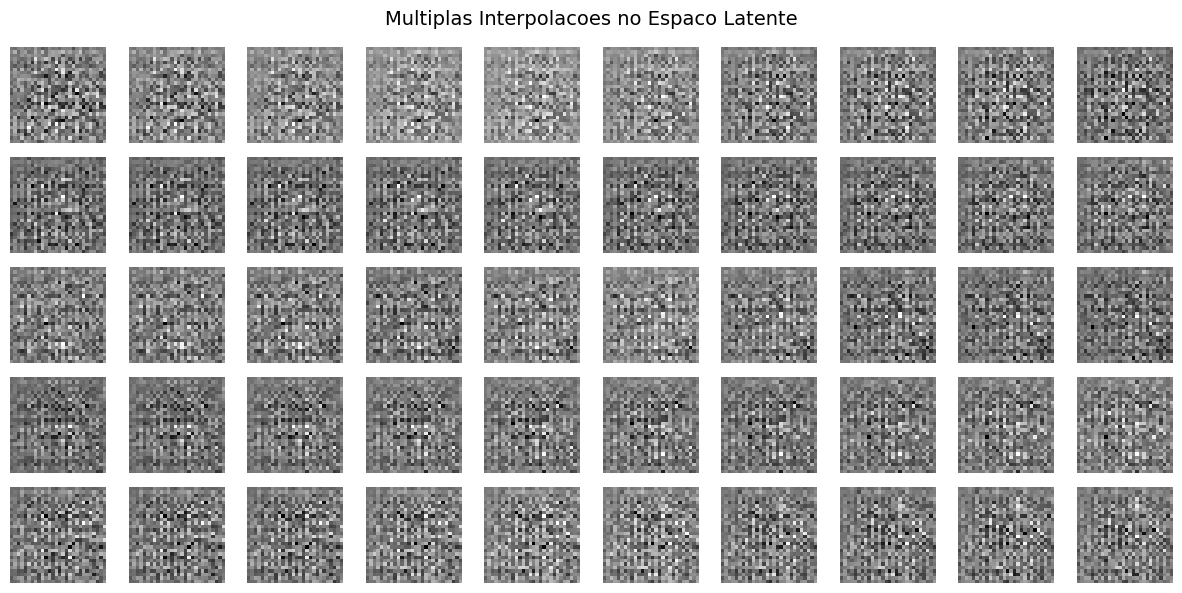

In [49]:
if show_latent_interpolation:
    #multiplas interpolacoes
    n_interpolations = 5
    n_steps = 10
    
    fig, axes = plt.subplots(n_interpolations, n_steps, figsize=(12, 6))
    
    for row in range(n_interpolations):
        interp_imgs = interpolarEspacoLatente(gerador, latent_dim, n_steps)
        for col in range(n_steps):
            axes[row, col].imshow(interp_imgs[col, :, :, 0], cmap='gray')
            axes[row, col].axis('off')
    
    plt.suptitle('Multiplas Interpolacoes no Espaco Latente', fontsize=14)
    plt.tight_layout()
    plt.show()

### 6.3 GIF da evolução do treinamento

In [50]:
if generate_evolution_gif and save_evolution_images:
    #criar gif da evolucao
    images = []
    filenames = sorted([f for f in os.listdir(evolution_folder) if f.endswith('.png')])
    
    for filename in filenames:
        images.append(imageio.imread(f'{evolution_folder}/{filename}'))
    
    #salvar gif
    gif_path = f'{evolution_folder}/{model_name}_evolucao.gif'
    imageio.mimsave(gif_path, images, fps=2)
    print(f'gif salvo em: {gif_path}')

ValueError: need at least one array to stack

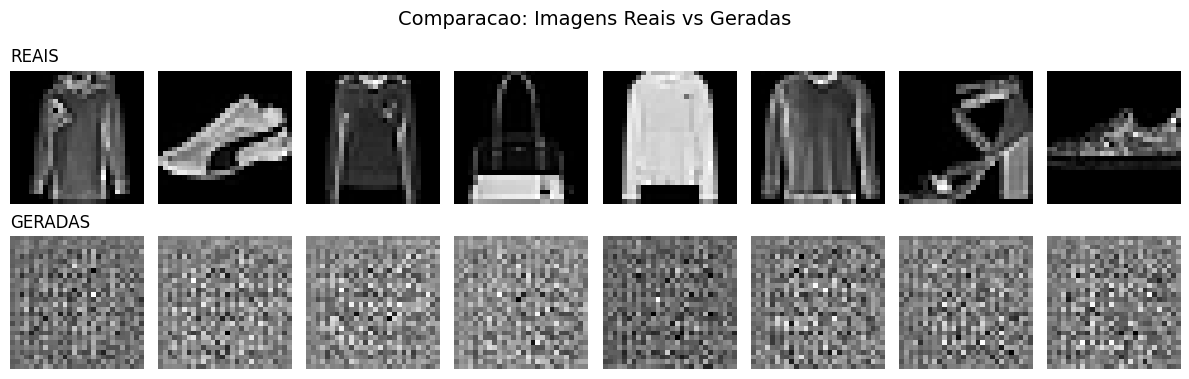

In [51]:
#comparacao: imagens reais vs geradas
fig, axes = plt.subplots(2, 8, figsize=(12, 4))

#imagens reais
idx = np.random.randint(0, x_train.shape[0], 8)
for i in range(8):
    axes[0, i].imshow((x_train[idx[i], :, :, 0] + 1) / 2, cmap='gray')
    axes[0, i].axis('off')
    if i == 0:
        axes[0, i].set_title('REAIS', fontsize=12, loc='left')

#imagens geradas
noise = gerarRuido(8, latent_dim)
gen_imgs = gerador.predict(noise, verbose=0)
gen_imgs = 0.5 * gen_imgs + 0.5
for i in range(8):
    axes[1, i].imshow(gen_imgs[i, :, :, 0], cmap='gray')
    axes[1, i].axis('off')
    if i == 0:
        axes[1, i].set_title('GERADAS', fontsize=12, loc='left')

plt.suptitle('Comparacao: Imagens Reais vs Geradas', fontsize=14)
plt.tight_layout()
plt.show()